# Data engineer skills Project

The objective of this project is to highlight the most in-demand skills for data engineer roles in France.

How it is done : 
1. Extract job postings for data engineer roles from a personal database.
2. Format description and look for most demanded skills.
3. Summarize the results visually.
4. Extract skils from courses syllabus. 

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import logging
from datetime import datetime
from sqlalchemy import create_engine, Table, MetaData, text
import re
import regex as re
import matplotlib.pyplot as plt
import pdfplumber

## Configuration

In [2]:
# Logging
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(LOG_DIR, f"pipeline_{datetime.now().strftime('%Y-%m-%d')}.log"),
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [3]:
##################  VARIABLES  ##################
# Param Database PostgreSQL
DB_NAME = os.environ.get("DB_NAME", "jobsdb")
DB_USER = os.environ.get("DB_USER","jobsuser")
DB_PASS = os.environ.get("DB_PASS", "jobspass")
DB_HOST = os.environ.get("DB_HOST", "localhost")
DB_PORT = os.environ.get("DB_PORT","5432")

# Nom table
DB_TABLE_NAME = "offres_table"

## Extract data from database

In [4]:
### Connect to database
def export_from_database(engine, table_name):
    # logging.info("Connect to database.")
    try:  
        query = text(f"""
            SELECT     
                   id, 
                   source,
                   recherche,
                   titre,
                   description,
                   departement,
                   date_publication               
            FROM {table_name}
            WHERE recherche = 'data engineer'
        """)
        
        with engine.connect() as conn:
            result = conn.execute(query)       
            df_extract = pd.DataFrame(result.fetchall(),columns=["id", 
                                                               "source",
                                                               "recherche",
                                                               "titre",
                                                               "description",
                                                               "departement",
                                                               "date_publication"])    
            return df_extract
            
    except requests.RequestException as e:
        logging.error(f"Error database export: {e}")
        return []

In [5]:
# Connexion DB
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

#Extract data from DB
df = export_from_database(engine, DB_TABLE_NAME)
# df = df.head(50)
display(df)

,id,source,recherche,titre,description,departement,date_publication
0,5558160344,Adzuna,data engineer,Data Engineer,Our client is a leader in comprehensive resour...,75,2025-12-28
1,8295963,France Travail,data engineer,Data Engineer F/H - Création (H/F),Descriptif du poste:\nLa ligne de service Cons...,44,2026-01-26
2,8295921,France Travail,data engineer,"DATA ENGINEER F/H - Système, réseaux, données ...",Descriptif du poste:\nLa ligne de service Cons...,33,2026-01-26
3,5498470331,Adzuna,data engineer,Data Engineer SQL/GCP F/H,1/ Au démarrage du projet : · Recueillir et an...,59,2025-11-15
4,1760694,France Travail,data engineer,DATA ENGINEER - H/F,Description :\n\n\nGS1 France a initié fin 202...,75,2025-09-02
...,...,...,...,...,...,...,...
4839,5909166,France Travail,data engineer,Expert TALEND-DATA Engineer (F/H) (H/F),Solide entreprise coopérative attachée à son t...,29,2025-11-27
4840,7495257,France Travail,data engineer,Expert TALEND-DATA Engineer (F/H) (H/F),Solide entreprise coopérative attachée à son t...,29,2026-01-06
4841,7624493,France Travail,data engineer,Expert TALEND-DATA Engineer (F/H) (H/F),Solide entreprise coopérative attachée à son t...,29,2026-01-08
4842,5540655641,Adzuna,data engineer,Tech Lead Data Engineer MLOps Aws H/F,Safran est un groupe international de haute te...,77,2025-12-13


## Data boundaries

In [6]:
# Convert publishing date column type from object to date 
df["date_publication"] = pd.to_datetime(df["date_publication"], format="%Y-%m-%d").dt.date

In [7]:
# Earliest job posting recorded in database
published_min = df["date_publication"].min()
published_min_formatted = published_min.strftime("%Y-%m-%d")

# Latest job posting recorded in database
published_max = df["date_publication"].max()
published_max_formatted = published_max.strftime("%Y-%m-%d")

In [8]:
# Data boundaries (min date, max date, search item)
data_boundaries = pd.DataFrame(
                                {
                                "recherche" : 'data engineer',
                                "Min date" : published_min_formatted,
                                "Max date" : published_max_formatted,
                                "# job postings" : df.shape[0]
                                 },
                                index = [1]
                            ).transpose()

display(data_boundaries)

,1
recherche,data engineer
Min date,2022-03-15
Max date,2026-01-27
# job postings,4844


## Clean and normalize job description

In [9]:
def clean_text(text):
    # logging.info("Clean and normalize job description.")
    try: 
        # Converts everything to lowercase
        text = text.lower()
    
        # It replaces anything like <tag>...</tag> with a space.
        text = re.sub(r"<.*?>", " ", text)     # HTML
    
        # Removes unwanted characters (but keeps French accents)
        # This line keeps only:
        # - lowercase letters a–z
        # - digits 0–9
        # - + . /
        # - spaces
        # Everything else becomes a space.
        text = re.sub(r"[^\p{L}0-9+./ ]", " ", text)
    
        # Cleans extra spaces
        # - \s+ = multiple spaces
        # - Replaces them with one single space
        # - .strip() removes spaces at the beginning and end
        text = re.sub(r"\s+", " ", text).strip()
        return text
    except requests.RequestException as e:
        logging.error(f"Error cleaning and normalizing process: {e}")
        return []

df["clean_description"] = df["description"].astype(str).apply(clean_text)

## Extract skills

In [10]:
DATA_ENGINEER_ONTOLOGY = {
    "Langages": [
        "python", "sql", "scala", "java", "bash","shell"
    ],
    "Bases_de_donnees": [
        "postgresql", "mysql", "sql server", "oracle",
        "snowflake", "bigquery", "redshift", "synapse",
        "mongodb", "cassandra", "dynamodb", "elasticsearch", "nosql"
    ],
    "Modelisation_et_architecture": [
        "data modeling", "dimensional modeling",
        "star schema", "snowflake schema",
        "data warehouse", "data lake", "lakehouse",
        "lambda architecture", "medallion architecture"
    ],
    "Pipelines_et_orchestration": [
        "etl", "elt", "data pipeline", "ingestion","pipeline", "orchestration",
        "airflow", "dagster", "prefect"
    ],
    "Big_Data": [
        "spark", "pyspark", "hadoop",
        "distributed computing", "partitioning"
    ],
    "Streaming": [
        "kafka", "kinesis", "pubsub", "event streaming"
    ],
    "Cloud": [
        "aws", "gcp", "azure",
        "s3", "gcs", "adls",
        "glue", "dataproc", "databricks"
    ],
    "DevOps_DataOps": [
        "docker", "kubernetes", "ci/cd",
        "terraform", "infrastructure as code"
    ],
    "Qualite_et_gouvernance": [
        "data quality", "data validation", "monitoring",
        "data governance", "data lineage", "rgpd"
    ],
    "Analytics_enablement": [
        "dbt", "semantic layer",
        "power bi", "tableau", "looker","excel"
    ]
}

In [11]:
def extract_skills(text, ontology):
    # logging.info("Extract skills from job description.")
    try:     
        found_skills = set()
        for category, skills in ontology.items():
            for skill in skills:
                if skill in text:
                    found_skills.add(skill)
        return list(found_skills)
    except requests.RequestException as e:
        logging.error(f"Error during extracting skills process: {e}")
        return []

df["skills_found"] = df["clean_description"].apply(lambda x: extract_skills(x, DATA_ENGINEER_ONTOLOGY))
df[["id", "skills_found"]].head()

,id,skills_found
0,5558160344,[]
1,8295963,"[kafka, etl, nosql, elt, aws, sql, python, gcp..."
2,8295921,"[kafka, etl, nosql, hadoop, sql, airflow, pyth..."
3,5498470331,"[sql, shell]"
4,1760694,"[pipeline, python, azure, ci/cd]"


In [12]:
# Long-form exploitation
skills_long = df.explode("skills_found")
skills_long = skills_long.dropna(subset=["skills_found"])

skills_long[["skills_found"]].head()

,skills_found
1,kafka
1,etl
1,nosql
1,elt
1,aws


## Frequency statistics

In [13]:
# Count the total number of postings
total_offres = df["id"].nunique()
print(total_offres)

# Count the number of postings mentionning a specific skill
skills_stats = (
    skills_long.groupby("skills_found")["id"]
    .nunique()
    .reset_index()
    .rename(columns={"id": "nb_offres"})
)

# Compute the percentage of postings mentionning a specific skill
skills_stats["pourcentage"] = (skills_stats["nb_offres"] / total_offres * 100).round(1)
skills_stats = skills_stats.sort_values("pourcentage", ascending=False)
skills_stats.head(10)

4844


,skills_found,nb_offres,pourcentage
45,pipeline,1129,23.3
60,sql,795,16.4
51,python,704,14.5
55,scala,572,11.8
3,azure,527,10.9
59,spark,524,10.8
23,etl,479,9.9
25,gcp,467,9.6
24,excel,417,8.6
2,aws,403,8.3


## Visualization

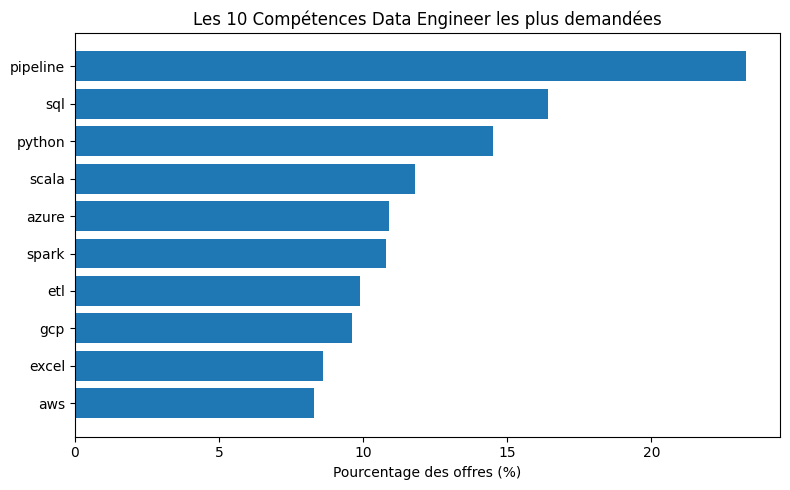

In [14]:
# Display the top n in-demand skills
top_n = 10

# Plot the percentage of job postings mentionning a specific skill
plt.figure(figsize=(8, 5))
plt.barh(
    skills_stats.head(top_n)["skills_found"],
    skills_stats.head(top_n)["pourcentage"]
)
plt.xlabel("Pourcentage des offres (%)")
plt.title(f"Les {top_n} Compétences Data Engineer les plus demandées")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Personal skills

In [15]:
all_values = [
    item
    for values in DATA_ENGINEER_ONTOLOGY.values()
    for item in values
]
all_values;

In [16]:
candidate_skills = {
                    'python' : "acquired",
                     'sql' : "acquired",
                     'scala' : "to be acquired",
                     'java' : "partially",
                     'bash' : "partially",
                     'postgresql' : "partially",
                     'mysql' : "partially",
                     'sql server' : "partially",
                     'oracle' : "to be acquired",
                     'snowflake' : "to be acquired",
                     'bigquery' : "partially",
                     'redshift': "to be acquired",
                     'synapse': "to be acquired",
                     'mongodb': "to be acquired",
                     'cassandra': "to be acquired",
                     'dynamodb': "to be acquired",
                     'elasticsearch': "to be acquired",
                     'data modeling': "acquired",
                     'dimensional modeling': "partially",
                     'star schema': "acquired",
                     'snowflake schema' : "acquired",
                     'data warehouse': "partially",
                     'data lake': "partially",
                     'lakehouse': "partially",
                     'lambda architecture': "to be acquired",
                     'medallion architecture': "to be acquired",
                     'etl': "partially",
                     'elt': "partially",
                     'data pipeline': "partially",
                     'ingestion': "to be acquired",
                     'airflow': "partially",
                     'dagster': "to be acquired",
                     'prefect': "partially",
                     'spark' : "to be acquired",
                     'pyspark': "to be acquired",
                     'hadoop': "to be acquired",
                     'distributed computing': "partially",
                     'partitioning': "partially",
                     'kafka': "to be acquired",
                     'kinesis': "to be acquired",
                     'pubsub': "to be acquired",
                     'event streaming': "to be acquired",
                     'aws': "to be acquired",
                     'gcp': "partially",
                     'azure': "partially",
                     's3': "to be acquired",    
                     'gcs': "to be acquired",
                     'adls': "to be acquired",
                     'glue': "to be acquired",
                     'dataproc': "to be acquired",
                     'databricks': "to be acquired",
                     'docker' : "partially",
                     'kubernetes': "to be acquired",
                     'ci/cd': "to be acquired",
                     'terraform': "to be acquired",
                     'infrastructure as code': "acquired",
                     'data quality': "partially",
                     'data validation': "acquired",
                     'monitoring': "partially",
                     'data governance': "partially",
                     'data lineage': "partially",
                     'rgpd': "partially",
                     'dbt': "to be acquired",
                     'semantic layer': "to be acquired",
                     'power bi': "acquired",
                     'tableau': "to be acquired",
                     'looker': "acquired",
                     'excel': "partially",
                     'shell': "partially",
                     'nosql' : "to be acquired",
                     'pipeline': "partially",
                    'orchestration' : "partially"
}

df_candidat = pd.DataFrame.from_dict(candidate_skills, orient="index", columns=["level"]
                                    ).reset_index().rename(columns={"index": "skill"})
df_candidat.head()

,skill,level
0,python,acquired
1,sql,acquired
2,scala,to be acquired
3,java,partially
4,bash,partially


## Extract skills from syllabus

In [17]:
# Define features of different training courses
data_engineer_LeWagon = {
    "syllabus_path" : "../data/raw_data/Data Engineering Syllabus_FR_LeWagon.pdf",
    "name" : "Le Wagon",
    "skills" : []    
}

data_engineer_DataScientest = {
    "syllabus_path" : "../data/raw_data/FR_Syllabus+Data+Engineer_2023_051023_DataScientest.pdf",
    "name" : "Data Scientest",
    "skills" : []    
}

data_engineer_Spiced = {
    "syllabus_path" : "../data/raw_data/Data_Engeneering_Spiced.pdf",
    "name" : "Spiced",
    "skills" : []    
}

data_engineer_CodeBasics = {
    "syllabus_path" : "../data/raw_data/DE_Bootcamp_1_0_Brochure_CodeBasics.pdf",
    "name" : "Code Basics",
    "skills" : []    
}

data_engineer_WildCodeSchool = {
    "syllabus_path" : "../data/raw_data/guide_data engineer_WildCodeSchool.pdf",
    "name" : "Wild Code School",
    "skills" : []    
}
data_engineer_Artefact = {
    "syllabus_path" : "../data/raw_data/Programme Bootcamp Data Engineer_Artefact.pdf",
    "name" : "Artefact",
    "skills" : []    
}
data_engineer_LaCapsule = {
    "syllabus_path" : "../data/raw_data/Syllabus - Cloud & DevOps Engineer - juin 2025_LaCapsule.pdf",
    "name" : "La Capsule",
    "skills" : []    
}
data_engineer_Jedha = {
    "syllabus_path" : "../data/raw_data/Syllabus Jedha - Formations Métiers (FR)_Jedha.pdf",
    "name" : "Jedha",
    "skills" : []    
}
data_engineer_IronHack = {
    "syllabus_path" : "../data/raw_data/Syllabus_DE_EN_2026_IronHack.pdf",
    "name" : "Iron Hack",
    "skills" : []    
}

training_courses = [data_engineer_DataScientest,
                    data_engineer_LeWagon,
                    data_engineer_Spiced,
                    data_engineer_WildCodeSchool,
                    data_engineer_Artefact,
                    data_engineer_LaCapsule,
                    data_engineer_IronHack]

In [18]:
# Function to rerieve, clean and normalize the syllabus text

def retrieve_syllabus_text(path):
    # Retrieve syllabus text
    with pdfplumber.open(path) as pdf:
        texte_complet = ""
        for page in pdf.pages:
            texte_complet += page.extract_text() or ""
    
    # Clean and normalize text
    texte_complet_clean = clean_text(texte_complet)
    
    return texte_complet_clean

In [19]:
def extract_skills_in_training(text, ontology):
    # logging.info("Extract skills from training courses.")
    try:     
        found_skills = []
        for category, skills in ontology.items():
            for skill in skills:
                if skill in text:
                    found_skills.append(skill)
        return found_skills
    except requests.RequestException as e:
        logging.error(f"Error during extracting skills process (training courses): {e}")
        return []

# Extract the skills taught in each training course
for course in training_courses:
    texte_complet_clean = retrieve_syllabus_text(course["syllabus_path"])
    course["skills"] = extract_skills_in_training(texte_complet_clean, DATA_ENGINEER_ONTOLOGY)

## Skills taught by the training courses

In [20]:
# Format the skills from training courses into a Pandas dataframe
formations = {
    training_courses[0]["name"]: training_courses[0]["skills"],
    training_courses[1]["name"]: training_courses[1]["skills"],
    training_courses[2]["name"]: training_courses[2]["skills"],
    training_courses[3]["name"]: training_courses[3]["skills"],
    training_courses[4]["name"]: training_courses[4]["skills"],
    training_courses[5]["name"]: training_courses[5]["skills"],
    training_courses[6]["name"]: training_courses[6]["skills"],
}

df_formations = pd.DataFrame.from_dict(formations, orient="index").transpose()
display(df_formations.head(3))

,Data Scientest,Le Wagon,Spiced,Wild Code School,Artefact,La Capsule,Iron Hack
0,python,python,python,python,python,python,python
1,sql,sql,sql,sql,sql,sql,sql
2,scala,postgresql,scala,scala,shell,scala,scala


In [26]:
# Merge in-demand skill with current candidate status
matrix = skills_stats.merge(df_candidat, left_on="skills_found", right_on="skill", how="left")
matrix = matrix.drop(columns=['skill'])

# Display most in-demand skills on job market and matching skills taught in training courses
for formation, skills in formations.items():
    matrix[formation] = matrix["skills_found"].apply(
        lambda x: "✓" if x in skills else ""
    )

display(data_boundaries)
display(matrix.head(20))

,1
recherche,data engineer
Min date,2022-03-15
Max date,2026-01-27
# job postings,4844


,skills_found,nb_offres,pourcentage,level,Data Scientest,Le Wagon,Spiced,Wild Code School,Artefact,La Capsule,Iron Hack
0,pipeline,1129,23.3,partially,✓,✓,✓,✓,✓,✓,✓
1,sql,795,16.4,acquired,✓,✓,✓,✓,✓,✓,✓
2,python,704,14.5,acquired,✓,✓,✓,✓,✓,✓,✓
3,scala,572,11.8,to be acquired,✓,,✓,✓,,✓,✓
4,azure,527,10.9,partially,✓,,,,,,
5,spark,524,10.8,to be acquired,✓,✓,✓,,✓,,✓
6,etl,479,9.9,partially,,✓,,✓,✓,,✓
7,gcp,467,9.6,partially,,✓,,,✓,,
8,excel,417,8.6,partially,✓,✓,✓,✓,,,
9,aws,403,8.3,to be acquired,✓,,✓,,,✓,
